This Notebook mostly follows along with [Transformer model for language understanding](https://www.tensorflow.org/tutorials/text/transformer)

The main differences is that I used the [Attention layer built into keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention) and used keras model.fit to train the model

I found [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) useful for understanding Attention and Transformers

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

Check if using a GPU.  
Turn on the GPU in Colab: 'Runtime' -> 'Change runtime type', select GPU in the dropdown menu   
It is reccomended to leave the GPU off untill you need it for training.

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data and input Pipline


Used [Portugese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en) from TensorFlow Datasets([tfds](https://www.tensorflow.org/datasets/api_docs/python/tfds))

The dataset include other language pairs that you could try to use

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteAIZXM3/ted_hrlr_translate-trai…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteAIZXM3/ted_hrlr_translate-vali…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteAIZXM3/ted_hrlr_translate-test…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [ ]:
[en.numpy() for pt, en in train_examples.take(10)]

[b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .',
 b'but what if it were active ?',
 b"but they did n't test for curiosity .",
 b'and this conscious defiance is why i , as an agnostic , can still have faith .',
 b'you can use everything on the table on me .',
 b"`` i write a lot about `` '' security theater , '' '' which are products that make people feel secure , but do n't actually do anything . ''",
 b"and they 've put it deep down in an iron mine in minnesota , ok , deep under the ground , and in fact , in the last couple of days announced the most sensitive results so far .",
 b'see , some people might fear girls not liking them back .',
 b"no , what happened to us , chris , is that power , it 's priced off the margin .",
 b'back to my question : why did i stay ?']

Text tokenized using Byte Pair Encoding.

https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder

In [ ]:
#####Heiko fix deprecated error message######
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
  (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)
#############

# tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
#     (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

# tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
#     (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [ ]:
sample_string = 'Transformer is complicated.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 3635, 7877]
The original string: Transformer is complicated.
7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
3635 ----> complicated
7877 ----> .


Create a funtion to tokenize and add start and end tokens for both languages

In [ ]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

This is needed to use .map  
See https://www.tensorflow.org/tutorials/text/transformer#setup_input_pipeline for more detail

In [ ]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Drop example where the tokenization of either language is greater then 40
This is to keep things fast should work without this 

In [ ]:
MAX_LENGTH = 40

In [ ]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [ ]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [ ]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

# Positional Encoding
A vector added to the embedding to encode positional information

https://www.tensorflow.org/tutorials/text/transformer#positional_encoding

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


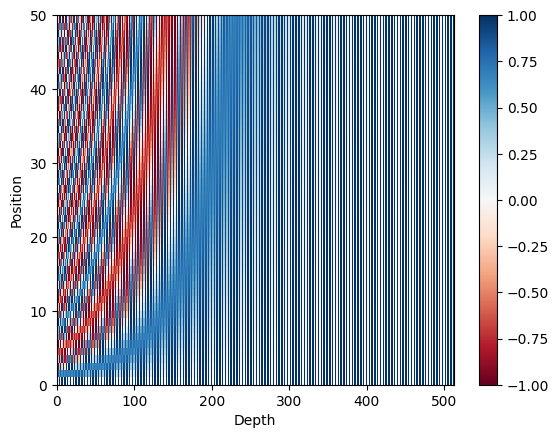

In [ ]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Attention

Basic attention test. Compare results with  
https://www.tensorflow.org/tutorials/text/transformer#scaled_dot_product_attention

Shape = (batch_size , seq_length, depth)

In [ ]:
query = tf.keras.layers.Input(shape=(None,3,))
value = tf.keras.layers.Input(shape=(4,2,)) 
key = tf.keras.layers.Input(shape=(4,3,))

x = tf.keras.layers.Attention()([query, value, key])
model = tf.keras.models.Model(inputs=[query, value, key], outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4, 2)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4, 3)]       0           []                               
                                                                                                  
 attention (Attention)          (None, None, 2)      0           ['input_1[0][0]',                
                                                                  'input_2[0][0]',            

In [ ]:
temp_k = tf.constant([[[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]]], dtype=tf.float32)  # (4, 2)

temp_q = tf.constant([[[0, 10, 0]]], dtype=tf.float32)  # (1, 3)
model.predict([temp_q,temp_v,temp_k])

1/1 [==============================] - 3s 3s/step


array([[[10.,  0.]]], dtype=float32)

In [ ]:
temp_q = tf.constant([[[0, 0, 10]]], dtype=tf.float32)  # (1, 3)
model.predict([temp_q,temp_v,temp_k])

1/1 [==============================] - 0s 20ms/step


array([[[550. ,   5.5]]], dtype=float32)

In [ ]:
temp_q = tf.constant([[[10, 10, 0]]], dtype=tf.float32)  # (1, 3)
model.predict([temp_q,temp_v,temp_k])

1/1 [==============================] - 0s 23ms/step


array([[[5.5, 0. ]]], dtype=float32)

In [ ]:
temp_q = tf.constant([[[0, 0, 10], [0, 10, 0], [10, 10, 0]]], dtype=tf.float32)  # (3, 3)
model.predict([temp_q,temp_v,temp_k])

1/1 [==============================] - 0s 44ms/step


array([[[550. ,   5.5],
        [ 10. ,   0. ],
        [  5.5,   0. ]]], dtype=float32)

test of Attention with comparable shapes to the 2nd attention block in the transformer decoder (except not multi headed)

In [ ]:
enc = tf.keras.layers.Input(shape=(40,512,))
tar = tf.keras.layers.Input(shape=(38,512,)) 

x = tf.keras.layers.Attention()([tar, enc, enc],mask = [None,None])
model = tf.keras.models.Model(inputs=[tar, enc], outputs=x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 38, 512)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 40, 512)]    0           []                               
                                                                                                  
 attention_1 (Attention)        (None, 38, 512)      0           ['input_5[0][0]',                
                                                                  'input_4[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                            

## Multi Headed Attention

Test of multi-headed Attention    
Shape = (batch_size , num_heads, seq_length, depth)

In [ ]:
num_heads = None
query = tf.keras.layers.Input(shape=(num_heads,None,3,))  
value = tf.keras.layers.Input(shape=(num_heads,4,2,)) 
key = tf.keras.layers.Input(shape=(num_heads,4,3,))

x = tf.keras.layers.Attention()([query, value, key])
model = tf.keras.models.Model(inputs=[query, value, key], outputs=x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 input_7 (InputLayer)           [(None, None, 4, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 input_8 (InputLayer)           [(None, None, 4, 3)  0           []                               
                                ]                                                           

In [ ]:
q = np.array([[[[0, 0, 10],     # head 1
                [0, 10, 0],
                [10, 10, 0]], 
               [[0, 0, 20],     # head 2
                [0, 20, 0],
                [10, 10, 0]]
               ]])
v = np.array([[[[   1,0],      # head 1
                [  10,0],
                [ 100,5],
                [1000,6]],
               [[   1, 0],     # head 2
                [   2, 0],
                [   3,15],
                [   4,20]]]])
k = np.array([[[[10,0,0],      # head 1
                [0,10,0],
                [0,0,10],
                [0,0,10]],
               [[10,0,5],      # head 2
                [0,10,0],
                [0,5,10],
                [5,0,10]]]])
 
model.predict([q,v,k])

1/1 [==============================] - 0s 47ms/step


array([[[[5.5000000e+02, 5.5000000e+00],
         [1.0000000e+01, 0.0000000e+00],
         [5.5000000e+00, 0.0000000e+00]],

        [[3.5000000e+00, 1.7500000e+01],
         [2.0000000e+00, 0.0000000e+00],
         [1.5000000e+00, 3.3753123e-21]]]], dtype=float32)

For each of [query, value, key]   
we reshape from  (batch_size , seq_length, depth) ->  (batch_size , seq_length, num_heads, multi_headed_depth)   
then permute  ->  (batch_size , num_heads, seq_length, multi_headed_depth)  
where multi-headed_depth = depth / num_heads

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model = 512, num_heads = 8, causal=False, dropout=0.0):
    super(MultiHeadAttention, self).__init__()

    assert d_model % num_heads == 0
    depth = d_model // num_heads

    self.w_query = tf.keras.layers.Dense(d_model)
    self.split_reshape_query = tf.keras.layers.Reshape((-1,num_heads,depth))  
    self.split_permute_query = tf.keras.layers.Permute((2,1,3))      

    self.w_value = tf.keras.layers.Dense(d_model)
    self.split_reshape_value = tf.keras.layers.Reshape((-1,num_heads,depth))
    self.split_permute_value = tf.keras.layers.Permute((2,1,3))

    self.w_key = tf.keras.layers.Dense(d_model)
    self.split_reshape_key = tf.keras.layers.Reshape((-1,num_heads,depth))
    self.split_permute_key = tf.keras.layers.Permute((2,1,3))

    self.attention = tf.keras.layers.Attention(causal=causal, dropout=dropout)
    self.join_permute_attention = tf.keras.layers.Permute((2,1,3))
    self.join_reshape_attention = tf.keras.layers.Reshape((-1,d_model))

    self.dense = tf.keras.layers.Dense(d_model)

  def call(self, inputs, mask=None, training=None):
    q = inputs[0]
    v = inputs[1]
    k = inputs[2] if len(inputs) > 2 else v

    query = self.w_query(q)
    query = self.split_reshape_query(query)    
    query = self.split_permute_query(query)                 

    value = self.w_value(v)
    value = self.split_reshape_value(value)
    value = self.split_permute_value(value)

    key = self.w_key(k)
    key = self.split_reshape_key(key)
    key = self.split_permute_key(key)

    if mask is not None:
      if mask[0] is not None:
        mask[0] = tf.keras.layers.Reshape((-1,1))(mask[0])
        mask[0] = tf.keras.layers.Permute((2,1))(mask[0])
      if mask[1] is not None:
        mask[1] = tf.keras.layers.Reshape((-1,1))(mask[1])
        mask[1] = tf.keras.layers.Permute((2,1))(mask[1])

    attention = self.attention([query, value, key], mask=mask)
    attention = self.join_permute_attention(attention)
    attention = self.join_reshape_attention(attention)

    x = self.dense(attention)

    return x

# Encoder and Decoder

## Encoder and Decoder Layers

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,  d_model = 512, num_heads = 8, dff = 2048, dropout = 0.0):
    super(EncoderLayer, self).__init__()

    self.multi_head_attention =  MultiHeadAttention(d_model, num_heads)
    self.dropout_attention = tf.keras.layers.Dropout(dropout)
    self.add_attention = tf.keras.layers.Add()
    self.layer_norm_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
    self.dense2 = tf.keras.layers.Dense(d_model)
    self.dropout_dense = tf.keras.layers.Dropout(dropout)
    self.add_dense = tf.keras.layers.Add()
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, inputs, mask=None, training=None):
    # print(mask)
    attention = self.multi_head_attention([inputs,inputs,inputs], mask = [mask,mask])
    attention = self.dropout_attention(attention, training = training)
    x = self.add_attention([inputs , attention])
    x = self.layer_norm_attention(x)
    # x = inputs

    ## Feed Forward
    dense = self.dense1(x)
    dense = self.dense2(dense)
    dense = self.dropout_dense(dense, training = training)
    x = self.add_dense([x , dense])
    x = self.layer_norm_dense(x)

    return x

the causal = True argument for multi_head_attention1 automatically masks  future tokens in the sequence

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,  d_model = 512, num_heads = 8, dff = 2048, dropout = 0.0):
    super(DecoderLayer, self).__init__()

    self.multi_head_attention1 =  MultiHeadAttention(d_model, num_heads, causal = True)
    self.dropout_attention1 = tf.keras.layers.Dropout(dropout)
    self.add_attention1 = tf.keras.layers.Add()
    self.layer_norm_attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.multi_head_attention2 =  MultiHeadAttention(d_model, num_heads)
    self.dropout_attention2 = tf.keras.layers.Dropout(dropout)
    self.add_attention2 = tf.keras.layers.Add()
    self.layer_norm_attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)


    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
    self.dense2 = tf.keras.layers.Dense(d_model)
    self.dropout_dense = tf.keras.layers.Dropout(dropout)
    self.add_dense = tf.keras.layers.Add()
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, inputs, mask=None, training=None):
    # print(mask)
    attention = self.multi_head_attention1([inputs[0],inputs[0],inputs[0]], mask = [mask[0],mask[0]])
    attention = self.dropout_attention1(attention, training = training)
    x = self.add_attention1([inputs[0] , attention])
    x = self.layer_norm_attention1(x)
    
    attention = self.multi_head_attention2([x, inputs[1],inputs[1]], mask = [mask[0],mask[1]])
    attention = self.dropout_attention2(attention, training = training)
    x = self.add_attention1([x , attention])
    x = self.layer_norm_attention1(x)


    ## Feed Forward
    dense = self.dense1(x)
    dense = self.dense2(dense)
    dense = self.dropout_dense(dense, training = training)
    x = self.add_dense([x , dense])
    x = self.layer_norm_dense(x)

    return x

## Encoder and Decoder Blocks
The encoder/decoder block 

1.   embeds the input
2.   adds positional encoding to the embeding
3.   adds n encoder/decoder layers


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, num_layers = 4, d_model = 512, num_heads = 8, dff = 2048, maximum_position_encoding = 10000, dropout = 0.0):
    super(Encoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=True)
    self.pos = positional_encoding(maximum_position_encoding, d_model)

    self.encoder_layers = [ EncoderLayer(d_model = d_model, num_heads = num_heads, dff = dff, dropout = dropout) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(dropout)

  def call(self, inputs, mask=None, training=None):
    x = self.embedding(inputs)
    # positional encoding
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # scaling by the sqrt of d_model, not sure why or if needed??
    x += self.pos[: , :tf.shape(x)[1], :]

    x = self.dropout(x, training=training)

    #Encoder layer
    embedding_mask = self.embedding.compute_mask(inputs)
    for encoder_layer in self.encoder_layers:
      x = encoder_layer(x, mask = embedding_mask)

    return x

  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, target_vocab_size, num_layers = 4, d_model = 512, num_heads = 8, dff = 2048, maximum_position_encoding = 10000, dropout = 0.0):
    super(Decoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model, mask_zero=True)
    self.pos = positional_encoding(maximum_position_encoding, d_model)

    self.decoder_layers = [ DecoderLayer(d_model = d_model, num_heads = num_heads, dff = dff, dropout = dropout)  for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(dropout)

  def call(self, inputs, mask=None, training=None):
    x = self.embedding(inputs[0])
    # positional encoding
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # scaling by the sqrt of d_model, not sure why or if needed??
    x += self.pos[: , :tf.shape(x)[1], :]

    x = self.dropout(x, training=training)

    #Decoder layer
    embedding_mask = self.embedding.compute_mask(inputs[0])
    for decoder_layer in self.decoder_layers:
      x = decoder_layer([x,inputs[1]], mask = [embedding_mask, mask])

    return x

  # Comment this out if you want to use the masked_loss()
  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs[0])

# Transformer model

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

dropout_rate = 0.1

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2


input = tf.keras.layers.Input(shape=(None,))
target = tf.keras.layers.Input(shape=(None,))
encoder = Encoder(input_vocab_size, num_layers = num_layers, d_model = d_model, num_heads = num_heads, dff = dff, dropout = dropout_rate)
decoder = Decoder(target_vocab_size, num_layers = num_layers, d_model = d_model, num_heads = num_heads, dff = dff, dropout = dropout_rate)

x = encoder(input)
x = decoder([target, x] , mask = encoder.compute_mask(input))
#  tf.keras.layers.Masking ??
x = tf.keras.layers.Dense(target_vocab_size)(x)

model = tf.keras.models.Model(inputs=[input, target], outputs=x)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 encoder (Encoder)              (None, None, 128)    1844736     ['input_9[0][0]']                
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, None)        0           ['input_9[0][0]']                
                                                                                            

predict before train to test everying is working

2/2 [==============================] - 0s 11ms/step


(64, 40, 8089)

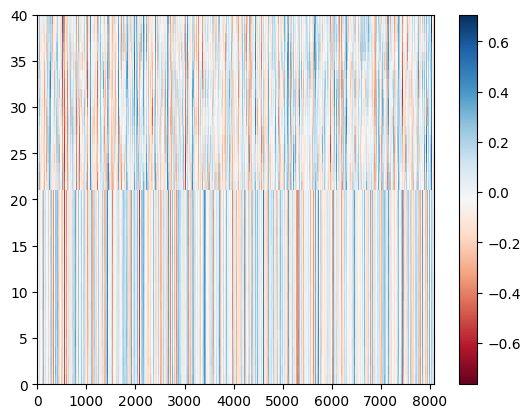

In [ ]:
pt_batch, en_batch = next(iter(val_dataset))
plt.pcolormesh(model.predict([pt_batch,en_batch])[5],cmap='RdBu')
plt.colorbar()
model.predict([pt_batch,en_batch]).shape

Custom schedule for optimizer. Works without this

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    #######Heiko fix error message########
    step = tf.cast(step, tf.float32)
    ##################
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    ########Heiko fix error message#######
    step = tf.cast(step, tf.float32)
    ###############
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Use Adam optimizer with the custom schedule above

Use Sparse Categorical Crossentropy loss with the madding masked.  
> If I knew what I was doing there should be a way to have the mask from the embedding properage though the entire model. Possible use tf.keras.layers.Masking at the end of the model?   
Adding 'def compute_mask' to the decoder did somthing not sure if it was what I wanted. Seems to be converging correctly but the loss values are lower then I expected

various different metrics to watch while fitting

Complie the model with all of the above

In [ ]:
optimizer = tf.keras.optimizers.Adam(CustomSchedule(d_model), beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def masked_loss(y_true, y_pred):
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  _loss = loss(y_true, y_pred)

  mask = tf.cast(mask, dtype=_loss.dtype)
  _loss *= mask

  return tf.reduce_sum(_loss)/tf.reduce_sum(mask)


metrics = [loss, masked_loss, tf.keras.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss = loss, metrics = metrics) # masked_

In [ ]:
num_batches = 0
for (batch, (_,_)) in enumerate(train_dataset):
  num_batches = batch
print(num_batches)

val_batches = 0
for (batch, (_,_)) in enumerate(val_dataset):
  val_batches = batch
print(val_batches)

702
16


## Training

when fitting we want input, target as inputs and target as an output. we need the target_input to be shifted 1 from the target_out.

used a generator to get what we want from train_dataset.

In [ ]:
def generator(data_set):
  while True:
    for pt_batch, en_batch in data_set:
      yield ( [pt_batch , en_batch[:, :-1] ] , en_batch[:, 1:] )


history = model.fit(x = generator(train_dataset), validation_data = generator(val_dataset), epochs=20, steps_per_epoch = num_batches, validation_steps = val_batches)

Epoch 1/20
702/702 [==============================] - 185s 206ms/step - loss: 3.4921 - sparse_categorical_crossentropy: 7.0194 - masked_loss: 7.1730 - sparse_categorical_accuracy: 0.1240 - val_loss: 2.6589 - val_sparse_categorical_crossentropy: 5.4189 - val_masked_loss: 5.7265 - val_sparse_categorical_accuracy: 0.2302
Epoch 2/20
702/702 [==============================] - 75s 105ms/step - loss: 2.4383 - sparse_categorical_crossentropy: 4.8937 - masked_loss: 5.1669 - sparse_categorical_accuracy: 0.2813 - val_loss: 2.2258 - val_sparse_categorical_crossentropy: 4.5362 - val_masked_loss: 4.7978 - val_sparse_categorical_accuracy: 0.3212
Epoch 3/20
702/702 [==============================] - 74s 105ms/step - loss: 2.1853 - sparse_categorical_crossentropy: 4.3872 - masked_loss: 4.6328 - sparse_categorical_accuracy: 0.3332 - val_loss: 2.0520 - val_sparse_categorical_crossentropy: 4.1821 - val_masked_loss: 4.4233 - val_sparse_categorical_accuracy: 0.3634
Epoch 4/20
702/702 [======================

2/2 [==============================] - 0s 11ms/step


(64, 40, 8089)

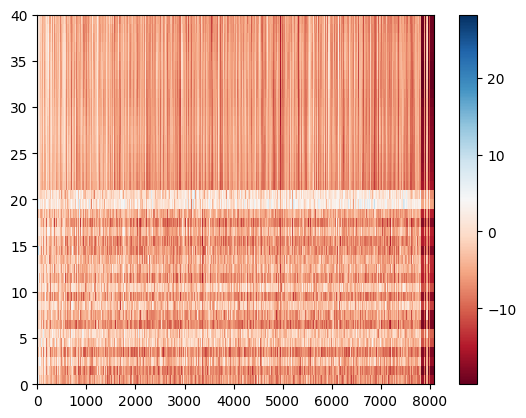

In [ ]:
pt_batch, en_batch = next(iter(val_dataset))
plt.pcolormesh(model.predict([pt_batch,en_batch])[5],cmap='RdBu')
plt.colorbar()
model.predict([pt_batch,en_batch]).shape

## Prediction
When predicting input what you want to translate to the encoder and input the start token to the decoder.   
Repeat this except use the output of the last prediction as the input to the decoder.  
Stop when the last value of the output is the stop token.

This final output (with the start and stop toekns removed ) can be fed to tokenizer_en.decode() to get an english sentence.

In [ ]:
for i in range(10):
  translation = [tokenizer_en.vocab_size]
  for _ in range(40):
    predict = model.predict([pt_batch[i:i+1],np.asarray([translation])])
    translation.append(np.argmax(predict[-1,-1]))
    if translation[-1] == tokenizer_en.vocab_size + 1:
      break

  real_translation = []
  for w in en_batch[:,1:][i].numpy():
    if w == tokenizer_en.vocab_size + 1:
      break
    real_translation.append(w)
  print(tokenizer_en.decode(real_translation))
  print(tokenizer_en.decode(translation[1:-1]))
  print("")


1/1 [==============================] - 0s 37ms/step
did they eat fish and chips ?
did they have tuckens with frids frids frits and loud ?

1/1 [==============================] - 0s 50ms/step
i was always worried about being caught and sent back .
i was always worried about being caung and sent back to the back of the back .

1/1 [==============================] - 0s 44ms/step
i chose one with the skin color of a lobster when sunburnt .
i chose a little shark of a lake with a dinosaur .

1/1 [==============================] - 0s 36ms/step
but i think this is quite clearly untrue .
but i think this is clearly fake .

1/1 [==============================] - 0s 35ms/step
we have measured our progress very rigorously .
we have measured our very deeply preciselying improvement .

1/1 [==============================] - 0s 37ms/step
and from what i feel , it 's a cure for me , but for us all .
and in my opinion , it 's not just a cure for me , but for everyone .

1/1 [==========================

# Simple Transformer using only Keras Functional API
* No Masking (
* No Multi-Headed attention  
* No Dropout
* Single Encoder and Decoder

In [ ]:
# tf.python.framework_ops.disable_eager_execution()

In [ ]:
d_model = 512
dff=2048
maximum_position_encoding = 10000
input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2

scaling_factor = tf.keras.backend.constant(np.sqrt(d_model), shape = (1,1,1))

# Encoder ##################################
input = tf.keras.layers.Input(shape=(None,))

x = tf.keras.layers.Embedding(input_vocab_size, d_model)(input) #, mask_zero=True

## positional encoding
x = tf.keras.layers.Multiply()([x,scaling_factor])
pos = positional_encoding(maximum_position_encoding, d_model)
x = tf.keras.layers.Add()([x, pos[: , :tf.shape(x)[1], :]] )

## self-attention
query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(x)
key = tf.keras.layers.Dense(d_model)(x)
attention = tf.keras.layers.Attention()([query, value, key])                   # , mask=[query._keras_mask, value._keras_mask]
attention = tf.keras.layers.Dense(d_model)(attention)

x = tf.keras.layers.Add()([x , attention])
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

## Feed Forward
dense = tf.keras.layers.Dense(dff, activation='relu')(x)
dense = tf.keras.layers.Dense(d_model)(dense)
x = tf.keras.layers.Add()([x , dense])                                          # residual connection
encoder = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

# Decoder ##################################
target = tf.keras.layers.Input(shape=(None,))

x = tf.keras.layers.Embedding(target_vocab_size, d_model )(target) # , mask_zero=True

## positional encoding
x = tf.keras.layers.Multiply()([x,scaling_factor])
pos = positional_encoding(maximum_position_encoding, d_model)
x = tf.keras.layers.Add()([x, pos[: , :tf.shape(x)[1], :] ])

## self-attention
query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(x)
key = tf.keras.layers.Dense(d_model)(x)
attention = tf.keras.layers.Attention(causal = True)([query, value, key])       # , mask=[query._keras_mask, value._keras_mask]
attention = tf.keras.layers.Dense(d_model)(attention)

x = tf.keras.layers.Add()([x , attention])                                      # residual connection
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

## encoder-decoder attention
query = tf.keras.layers.Dense(d_model)(x)
value = tf.keras.layers.Dense(d_model)(encoder)
key = tf.keras.layers.Dense(d_model)(encoder)
attention = tf.keras.layers.Attention()([query, value, key])                    # , mask=[query._keras_mask, value._keras_mask]
attention = tf.keras.layers.Dense(d_model)(attention)

x = tf.keras.layers.Add()([x , attention])                                      # residual connection
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

## Feed Forward
dense = tf.keras.layers.Dense(dff, activation='relu')(x)
dense = tf.keras.layers.Dense(d_model)(dense)
x = tf.keras.layers.Add()([x , dense])                                          # residual connection
decoder = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

######################################################

x = tf.keras.layers.Dense(target_vocab_size)(decoder)

base_model = tf.keras.models.Model(inputs=[input,target], outputs=x)
base_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 512)    4206592     ['input_11[0][0]']               
                                                                                                  
 multiply (Multiply)            (None, None, 512)    0           ['embedding_2[0][0]']            
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (3,)                0           ['multiply[0][0]']               
 )                                                                                          

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def masked_loss(y_true, y_pred):
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  _loss = loss(y_true, y_pred)

  mask = tf.cast(mask, dtype=_loss.dtype)
  _loss *= mask

  return tf.reduce_sum(_loss)/tf.reduce_sum(mask)


metrics = [loss, masked_loss, tf.keras.metrics.SparseCategoricalAccuracy()]

base_model.compile(optimizer=optimizer, loss = loss, metrics = metrics) # masked_

In [ ]:
def generator(data_set):
  while True:
    for pt_batch, en_batch in data_set:
      yield ( [pt_batch , en_batch[:, :-1] ] , en_batch[:, 1:] )

def training_map(pt, en):
  return [pt , en[:-1]] , en[1:]

# def tf_gen(pt, en):
#   input_pt, input_en, output_en = tf.py_function(gen, [pt, en], [tf.int64, tf.int64, tf.int64])
#   input_pt.set_shape([None])
#   input_en.set_shape([None])
#   output_en.set_shape([None])
#   return [input_pt, input_en], output_en


# history = base_model.fit(x = train_dataset.map(training_map), epochs=20)
history = base_model.fit(x = generator(train_dataset), validation_data = generator(val_dataset), epochs=20, steps_per_epoch = num_batches, validation_steps = val_batches)

Epoch 1/20
702/702 [==============================] - 120s 156ms/step - loss: 2.4552 - sparse_categorical_crossentropy: 2.4552 - masked_loss: 5.1857 - sparse_categorical_accuracy: 0.6364 - val_loss: 2.1191 - val_sparse_categorical_crossentropy: 2.1191 - val_masked_loss: 4.5656 - val_sparse_categorical_accuracy: 0.6696
Epoch 2/20
702/702 [==============================] - 66s 93ms/step - loss: 2.0195 - sparse_categorical_crossentropy: 2.0196 - masked_loss: 4.2769 - sparse_categorical_accuracy: 0.6683 - val_loss: 2.0680 - val_sparse_categorical_crossentropy: 2.0680 - val_masked_loss: 4.4563 - val_sparse_categorical_accuracy: 0.6709
Epoch 3/20
702/702 [==============================] - 62s 88ms/step - loss: 1.9084 - sparse_categorical_crossentropy: 1.9084 - masked_loss: 4.0495 - sparse_categorical_accuracy: 0.6725 - val_loss: 2.0460 - val_sparse_categorical_crossentropy: 2.0460 - val_masked_loss: 4.4083 - val_sparse_categorical_accuracy: 0.6741
Epoch 4/20
702/702 [========================

In [ ]:
for i in range(10):
  translation = [tokenizer_en.vocab_size]
  for _ in range(40):
    predict = base_model.predict([pt_batch[i:i+1],np.asarray([translation])])
    translation.append(np.argmax(predict[-1,-1]))
    if translation[-1] == tokenizer_en.vocab_size + 1:
      break

  real_translation = []
  for w in en_batch[:,1:][i].numpy():
    if w == tokenizer_en.vocab_size + 1:
      break
    real_translation.append(w)
  print(tokenizer_en.decode(real_translation))
  print(tokenizer_en.decode(translation[1:-1]))
  print("")


1/1 [==============================] - 0s 25ms/step
did they eat fish and chips ?
so what can we do we get to the future ?

1/1 [==============================] - 0s 24ms/step
i was always worried about being caught and sent back .
and i think of the world warps into a little bit of the system .

1/1 [==============================] - 0s 22ms/step
i chose one with the skin color of a lobster when sunburnt .
and then the next day , i was also had been a few weeks ago .

1/1 [==============================] - 0s 23ms/step
but i think this is quite clearly untrue .
and that 's the world we are .

1/1 [==============================] - 0s 23ms/step
we have measured our progress very rigorously .
and i think of the world warps into a little bit of the same time i was a lot of the world .

1/1 [==============================] - 0s 22ms/step
and from what i feel , it 's a cure for me , but for us all .
and i do n't have n't have to do n't have no one of the internet .

1/1 [==================

In [ ]:
print(tf.__version__)

2.12.0
